# This notebook shows how to load and analyse GAN generated sequences.
#### GAN generated sequences are provided in ./data/gan/generated_seqs folder.
#### Background sequences are provided in ./data/gan/background_seqs folder.
#### Genomic sequences are provided in ./data/gan folder
#### It consists of:
* Reading GAN generated, genomic, and background sequences.
* Scoring generated sequences with the DeepMEL model.
* Visualising prediction scores on gan generated sequences at different training steps.
* Comparing GC content of GAN generated and background sequences.
* Visializing the luciferase results and contribution score plots.
#### Luciferase values are in ./data/luciferase folder
#### Intermediate files are saved to ./data/gan folder
#### Figures are saved to ./figures/gan folder

### General imports


In [1]:
import sys  
import os
import pickle
import utils
import numpy as np
import scipy
import tensorflow as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use("default")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### Loading DeepMEL2 data to be used for the initialization of shap.DeepExplainer


In [2]:
print('Loading data...')
f = open('./data/deepmel2/DeepMEL2_nonAugmented_data.pkl', "rb")
nonAugmented_data_dict = pickle.load(f)
f.close()

Loading data...


### Loading the models and initializing shap.DeepExplainer


In [3]:
print('Loading model...')
import shap
tf.disable_eager_execution()
rn=np.random.choice(nonAugmented_data_dict["train_data"].shape[0], 250, replace=False)
model_dict = {}
exp_dict = {} 

name = "deepmel2"
model_json_file = "models/deepmel2/model.json"
model_hdf5_file = "models/deepmel2/model_epoch_07.hdf5"
model_dict[name] = utils.load_model(model_json_file, model_hdf5_file)
exp_dict[name] = shap.DeepExplainer((model_dict[name].inputs, model_dict[name].layers[-1].output), [nonAugmented_data_dict["train_data"][rn],nonAugmented_data_dict["train_data"][rn][:,::-1,::-1]])


name = "deepmel2_gabpa"
model_json_file = "models/deepmel2_gabpa/model.json"
model_hdf5_file = "models/deepmel2_gabpa/model_epoch_09.hdf5"
model_dict[name] = utils.load_model(model_json_file, model_hdf5_file)
exp_dict[name] = shap.DeepExplainer((model_dict[name].inputs, model_dict[name].layers[-1].output), [nonAugmented_data_dict["train_data"][rn],nonAugmented_data_dict["train_data"][rn][:,::-1,::-1]])


name = "deepmel"
model_json_file = "models/deepmel/model.json"
model_hdf5_file = "models/deepmel/model_best_loss.hdf5"
model_dict[name] = utils.load_model(model_json_file, model_hdf5_file)
exp_dict[name] = shap.DeepExplainer((model_dict[name].inputs, model_dict[name].layers[-1].output), [nonAugmented_data_dict["train_data"][rn],nonAugmented_data_dict["train_data"][rn][:,::-1,::-1]])


Loading model...


In [4]:
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

### Reading GAN generated, genomic, and background sequences and calculating prediction scores

In [10]:
# data_dict = {}
# data_dict["MMgan"] = {}
# for iter_ in range(0,161000,10000):
#     data_dict["MMgan"][iter_] = {}
#     data_dict["MMgan"][iter_]["seq"], data_dict["MMgan"][iter_]["ids"]= utils.prepare_data("data/gan/generated_seqs/generated_3968_iter_"+str(iter_)+".fa")
#     data_dict["MMgan"][iter_]["pred"] = model_dict["deepmel2"].predict([data_dict["MMgan"][iter_]["seq"],data_dict["MMgan"][iter_]["seq"][:,::-1,::-1]])
#     data_dict["MMgan"][iter_]["pred_deepmel"] = model_dict["deepmel"].predict([data_dict["MMgan"][iter_]["seq"],data_dict["MMgan"][iter_]["seq"][:,::-1,::-1]])
        
# data_dict["original"] = {}
# data_dict["original"]["seq"], data_dict["original"]["ids"] =  utils.prepare_data("data/gan/Genomic_MEL_regions.fa")
# data_dict["original"]["pred"] = model_dict["deepmel2"].predict([data_dict["original"]["seq"],data_dict["original"]["seq"][:,::-1,::-1]])
# data_dict["original"]["pred_deepmel"] = model_dict["deepmel"].predict([data_dict["original"]["seq"],data_dict["original"]["seq"][:,::-1,::-1]])

# data_dict["bg"] = {}
# for order in [0,1,2,3,4]:
#     data_dict["bg"][order] = {}
#     data_dict["bg"][order]["seq"], data_dict["bg"][order]["ids"] =  utils.prepare_data("data/gan/background_seqs/Genomic_MEL_regions.bg_o"+str(order)+".fa")
#     data_dict["bg"][order]["pred"] = model_dict["deepmel2"].predict([data_dict["bg"][order]["seq"],data_dict["bg"][order]["seq"][:,::-1,::-1]])
#     data_dict["bg"][order]["pred_deepmel"] = model_dict["deepmel"].predict([data_dict["bg"][order]["seq"],data_dict["bg"][order]["seq"][:,::-1,::-1]])

# import pickle 
# with open('data/gan/GAN_data_dict.pkl', 'wb') as f:
#     pickle.dump(data_dict, f)

import pickle 
with open('data/gan/GAN_data_dict.pkl', 'rb') as f:
    data_dict = pickle.load(f)

### Plotting prediction scores of the GAN generated sequences at different iterations as well as background sequences

3968


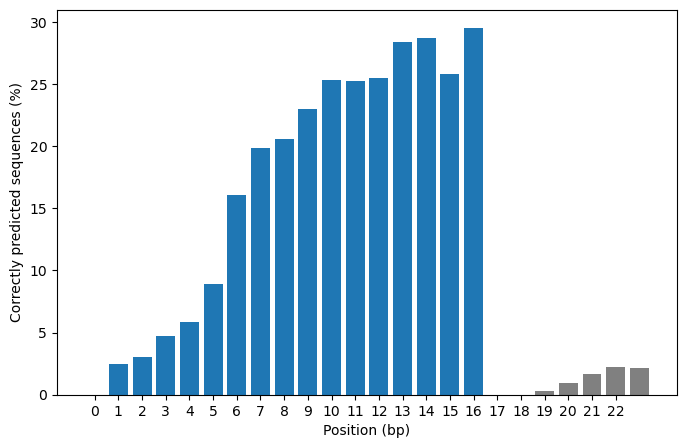

In [44]:
plt.figure(figsize=(8,5))
print(len(data_dict["bg"][0]["pred"]))
th = 0.15
for k,i in enumerate(range(0,161000,10000)):
    plt.bar(k,np.sum(data_dict["MMgan"][i]["pred_deepmel"][:,3]>th)/3968*100,color="C0")


for k,i in enumerate(range(5)):
    plt.bar(k+19,np.sum(data_dict["bg"][i]["pred_deepmel"][:,3]>th)/3968*100,color="gray")

_ = plt.xticks(range(23),range(23))

plt.xlabel("Position (bp)")
plt.ylabel("Correctly predicted sequences (%)")

plt.savefig("figures/gan/prediction_percentage_bar.pdf",transparent=True)

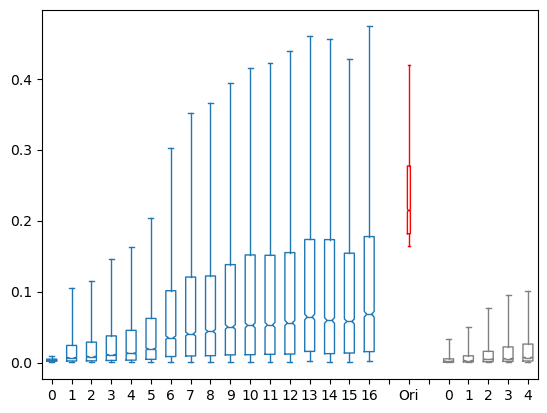

In [51]:
c = "C0"
_ = plt.boxplot([data_dict["MMgan"][key]["pred_deepmel"][:,3] for key in data_dict["MMgan"]],notch=True,showfliers=False, whis=[5,95],
                positions=list(range(0,17)),
                boxprops=dict(color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c),
                )
c = 'red'
_ = plt.boxplot(data_dict["original"]["pred_deepmel"][:,3],notch=True,showfliers=False, whis=[5,95],
                positions=list(range(18,19)),
                boxprops=dict(color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c),
                )
c = 'grey'
_ = plt.boxplot([data_dict["bg"][key]["pred_deepmel"][:,3] for key in data_dict["bg"]],notch=True,showfliers=False, whis=[5,95],
                positions=list(range(20,25)),
                boxprops=dict(color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c),
                )
_ = plt.xticks(range(25),list(range(0,17))+["","Ori",""]+list(range(5)))
plt.savefig("figures/gan/prediction_distribution_bar.pdf",transparent=True)

### Smoothed plotting of GC-content comparison of Genomic and GAN generated and background sequences

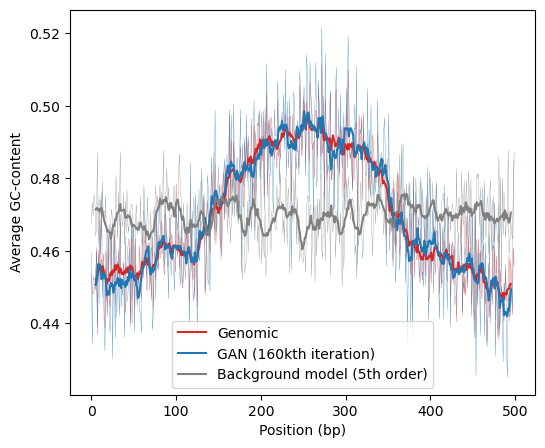

In [52]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

plt.figure(figsize=(6,5))
plt.plot((np.mean(data_dict["original"]["seq"][:,:,1] + data_dict["original"]["seq"][:,:,2],axis=0)),color="C3",linewidth=0.2)
plt.plot((np.mean(data_dict["MMgan"][160000]["seq"][:,:,1] + data_dict["MMgan"][160000]["seq"][:,:,2],axis=0)),color="C0",linewidth=0.2)
plt.plot((np.mean(data_dict["bg"][4]["seq"][:,:,1] + data_dict["bg"][4]["seq"][:,:,2],axis=0)),color="gray",linewidth=0.2)

smt_val = 10
plt.plot(range(5,496),smooth(np.mean(data_dict["original"]["seq"][:,:,1] + data_dict["original"]["seq"][:,:,2],axis=0),smt_val),label="Genomic",color="C3")
plt.plot(range(5,496),smooth(np.mean(data_dict["MMgan"][160000]["seq"][:,:,1] + data_dict["MMgan"][160000]["seq"][:,:,2],axis=0),smt_val),label="GAN (160kth iteration)",color="C0")
plt.plot(range(5,496),smooth(np.mean(data_dict["bg"][4]["seq"][:,:,1] + data_dict["bg"][4]["seq"][:,:,2],axis=0),smt_val),label="Background model (5th order)",color="gray")
plt.legend()

plt.xlabel("Position (bp)")
plt.ylabel("Average GC-content")

plt.savefig("figures/gan/GC_content_Genomic_Gan_Background.pdf",transparent=True)


### Loading and plotting luciferase results

In [53]:
luciferase_dict = {"ids":[],"values":[]}
with open("data/luciferase/GANall_IRF4_TYR_MLANA.txt","r") as fr:
    for line in fr:
        if line.startswith("id"):
            continue
        sep = line.strip().split("\t")
        luciferase_dict["ids"].append(sep[0])
        luciferase_dict["values"].append(sep[1:])
luciferase_dict["values"] = np.array(luciferase_dict["values"],dtype="float")

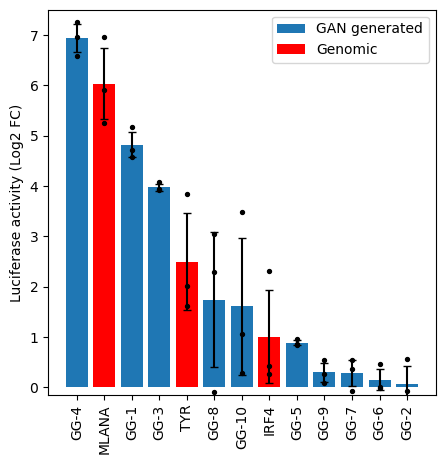

In [54]:
plt.figure(figsize=(5,5))
mean = np.mean(np.log2(luciferase_dict["values"]),axis=1)
std = np.std(np.log2(luciferase_dict["values"]),axis=1)

index = np.argsort(mean)[::-1]
temp = sorted(mean)[::-1]
res = [temp.index(i) for i in mean]

plt.bar(res[:10],mean[:10],color="C0",label="GAN generated",yerr=std[:10],capsize=3)
plt.bar(res[10:],mean[10:],color="red",label="Genomic",yerr=std[10:],capsize=3)
plt.legend()

for i in range(13):
    for k in np.log2(luciferase_dict["values"][i]):
        plt.scatter(res[i],k,color="black",zorder=10,s=8)
        
plt.ylim(-0.15,7.5)
_ = plt.xticks(range(13),np.array(luciferase_dict["ids"])[index],rotation=90)
plt.ylabel("Luciferase activity (Log2 FC)")
plt.savefig("figures/gan/GAN_selected_regions_luciferase_withdot.pdf",transparent=True)

### Plotting nucleotide contribution scores and in silico saturation mutagenesis values on the GAN-generated sequences

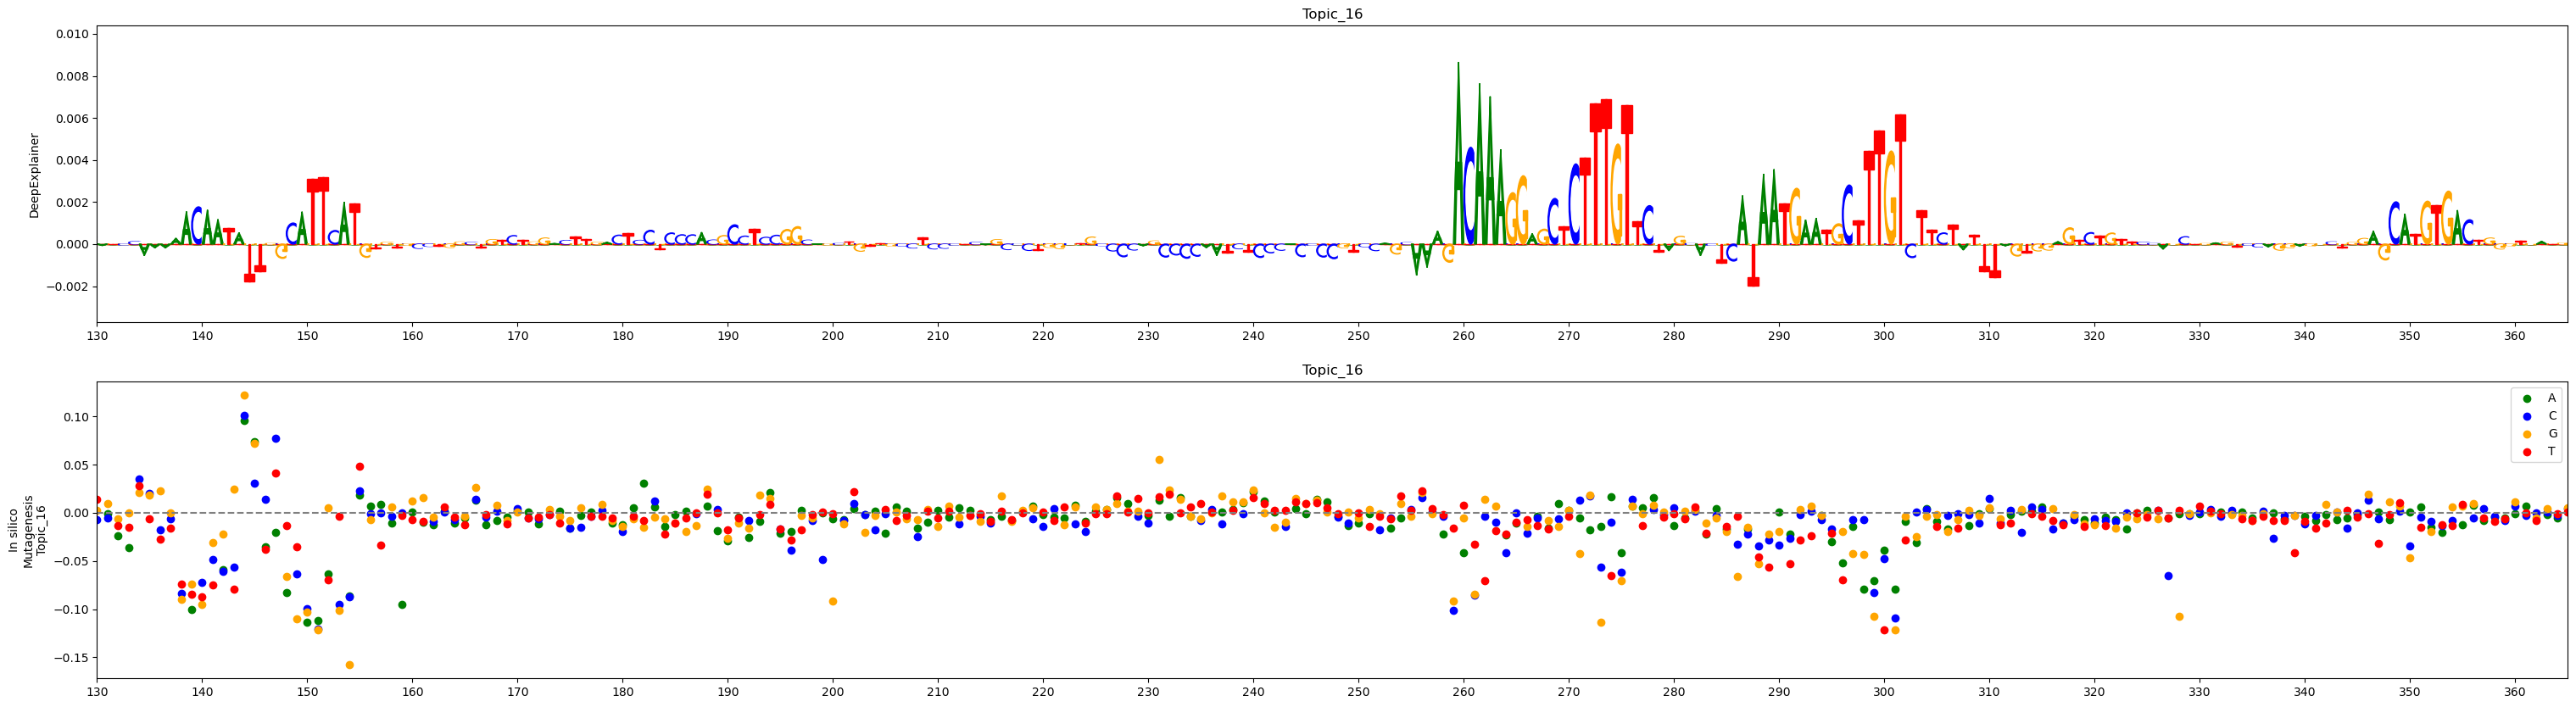

In [56]:
# 530_MMgan_160000 MM-GG-1
# 807_MMgan_160000 MM-GG-2
# 1015_MMgan_160000 MM-GG-3
# 1751_MMgan_160000 MM-GG-4
# 1747_MMgan_160000 MM-GG-5
# 1931_MMgan_160000 MM-GG-6
# 2113_MMgan_160000 MM-GG-7
# 2376_MMgan_160000 MM-GG-8
# 3045_MMgan_160000 MM-GG-9
# 3271_MMgan_160000 MM-GG-10

region = '530_MMgan_160000'  
ntrack = 2
fig = plt.figure(figsize=(37.6,ntrack*5))
seq_onehot = np.copy(data_dict["MMgan"][160000]["seq"][np.array(data_dict["MMgan"][160000]["ids"])==region])

st = 130
end = 365

ax1 = utils.plot_deepexplainer_givenax_withrc(explainer=exp_dict["deepmel2"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=seq_onehot, class_no = 16)
ax2 = utils.plot_mutagenesis_givenax_fast_withrc(model=model_dict["deepmel2"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=seq_onehot, class_no = 16)

ax1.set_xlim([st,end])
ax2.set_xlim([st,end])

plt.savefig("figures/gan/530_MMgan_160000_GG1_st130_end365_deepexplainer_topic16.pdf",transparent=True)


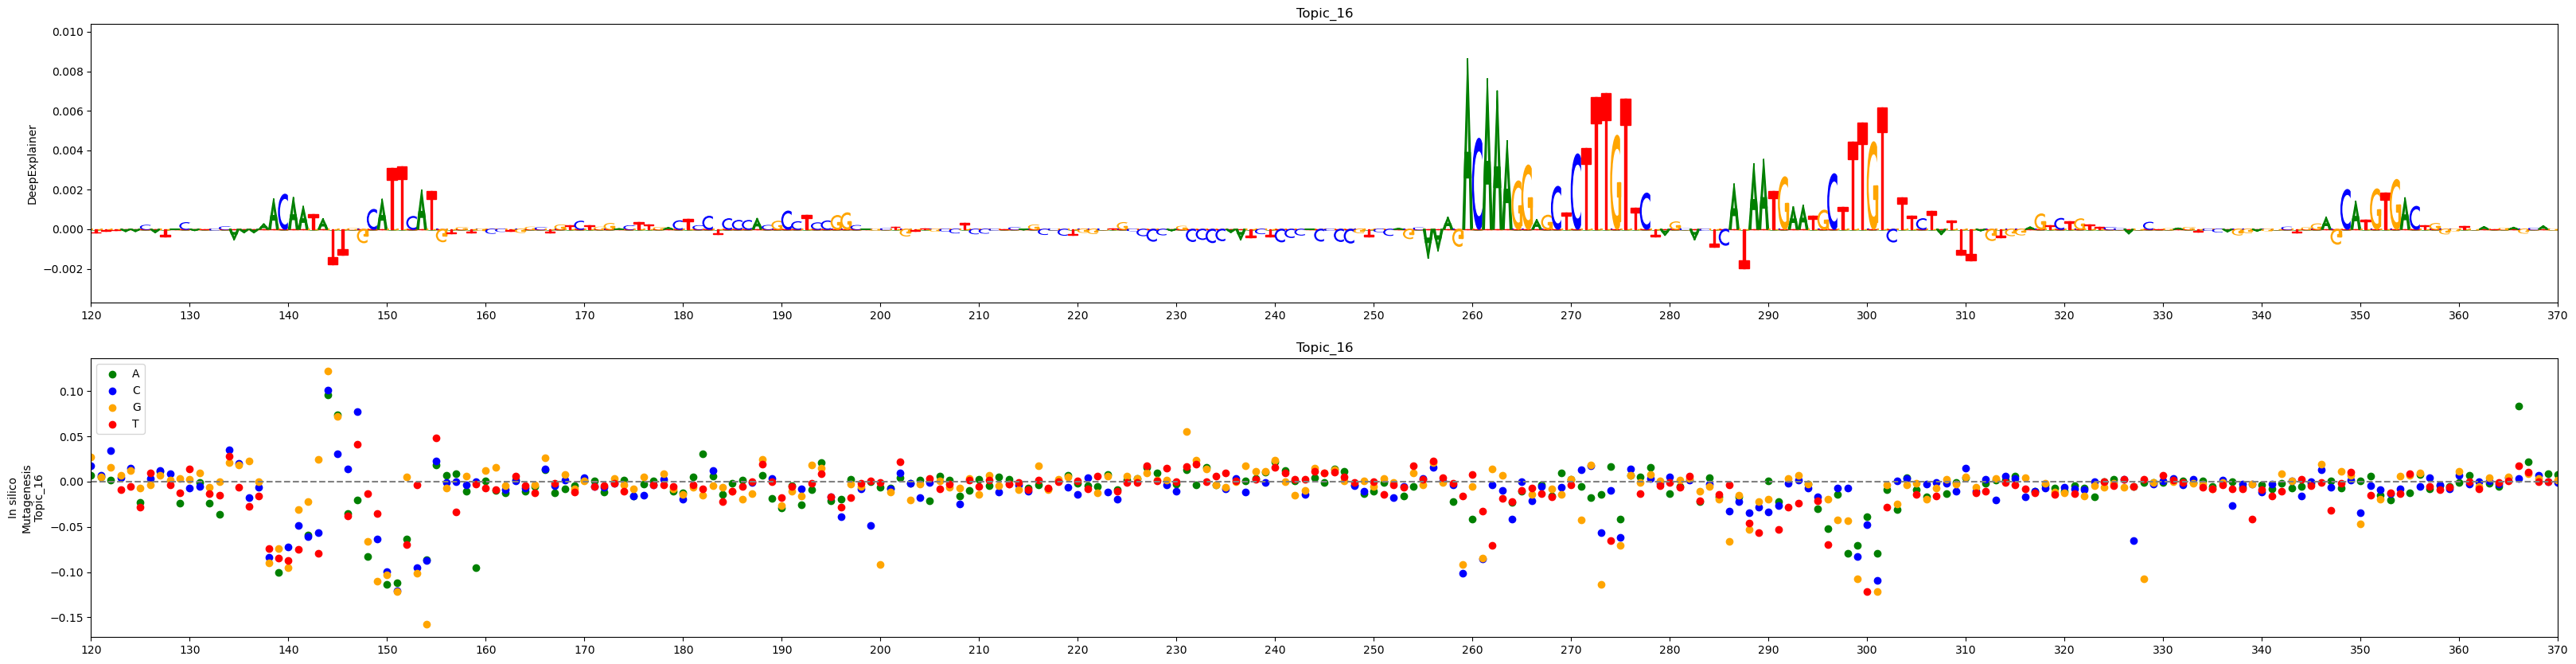

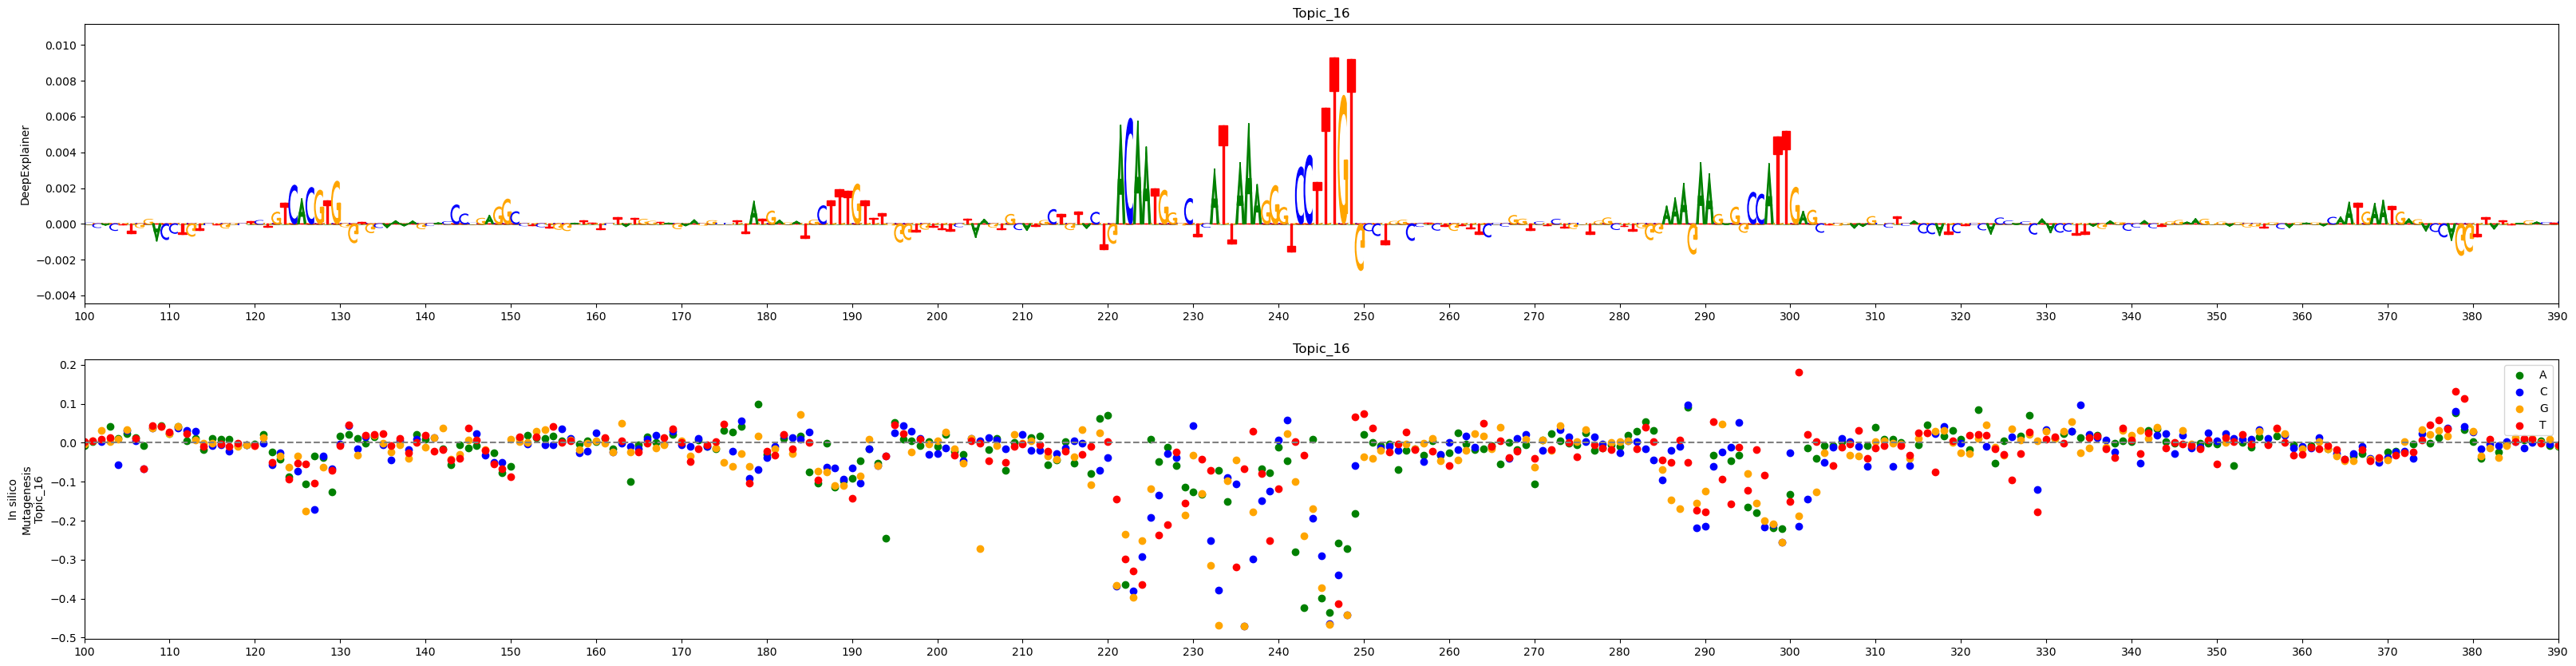

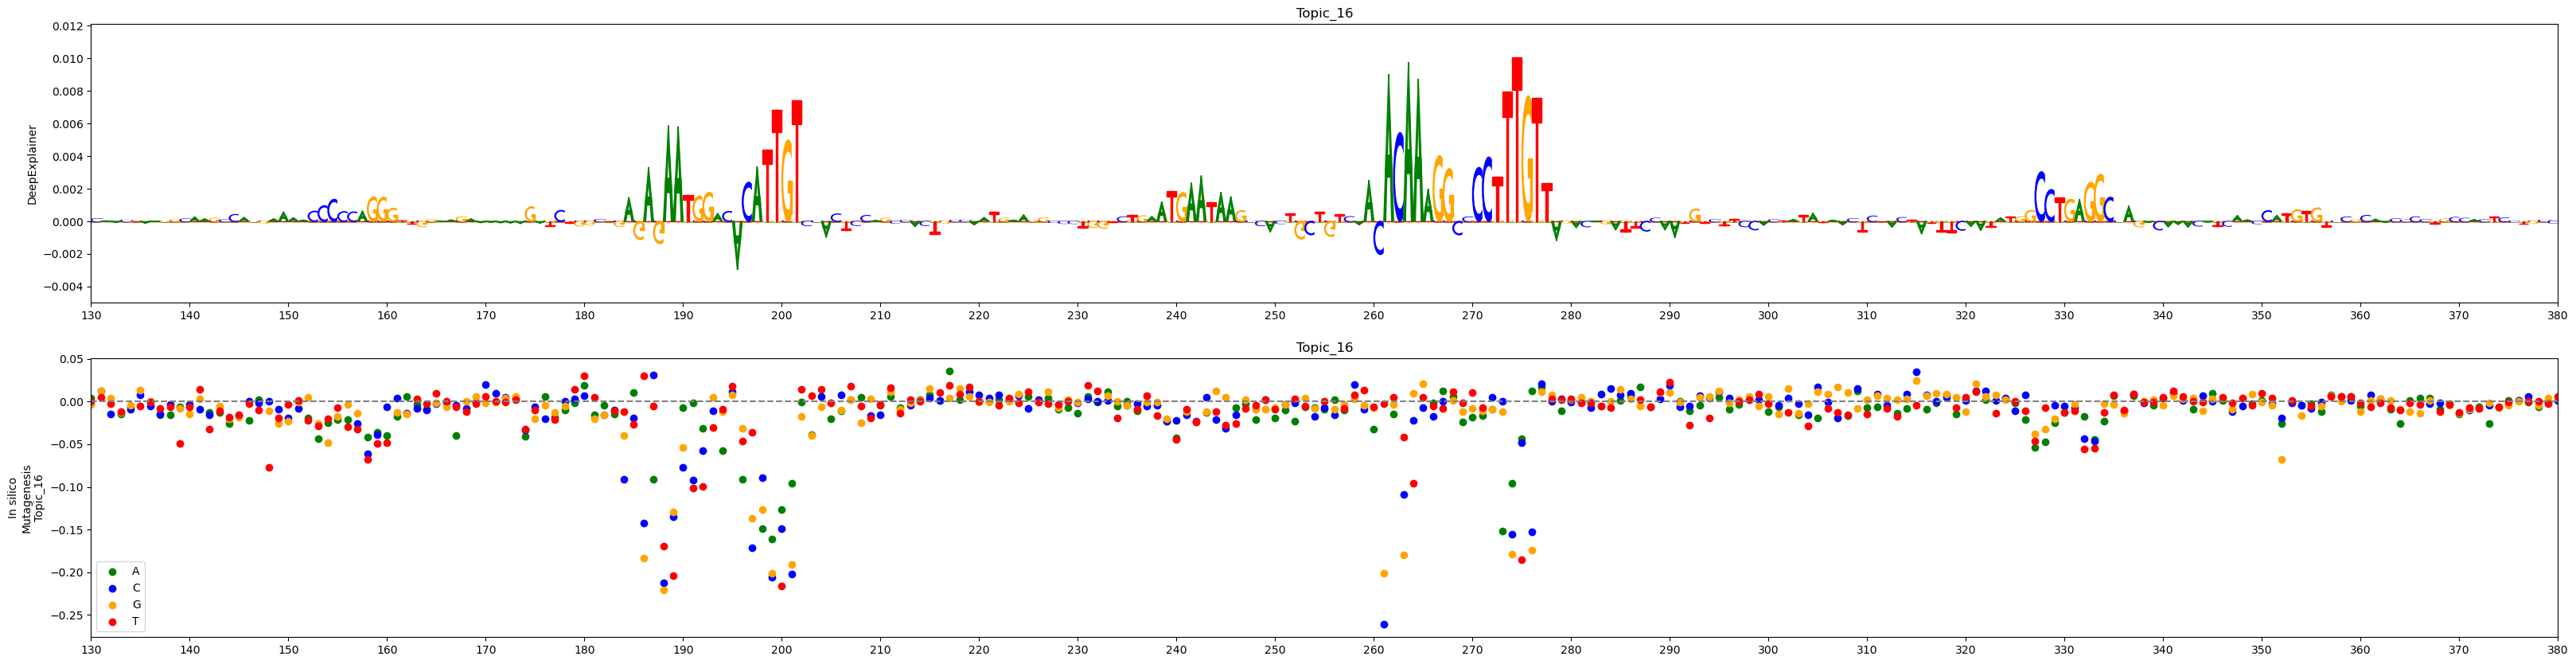

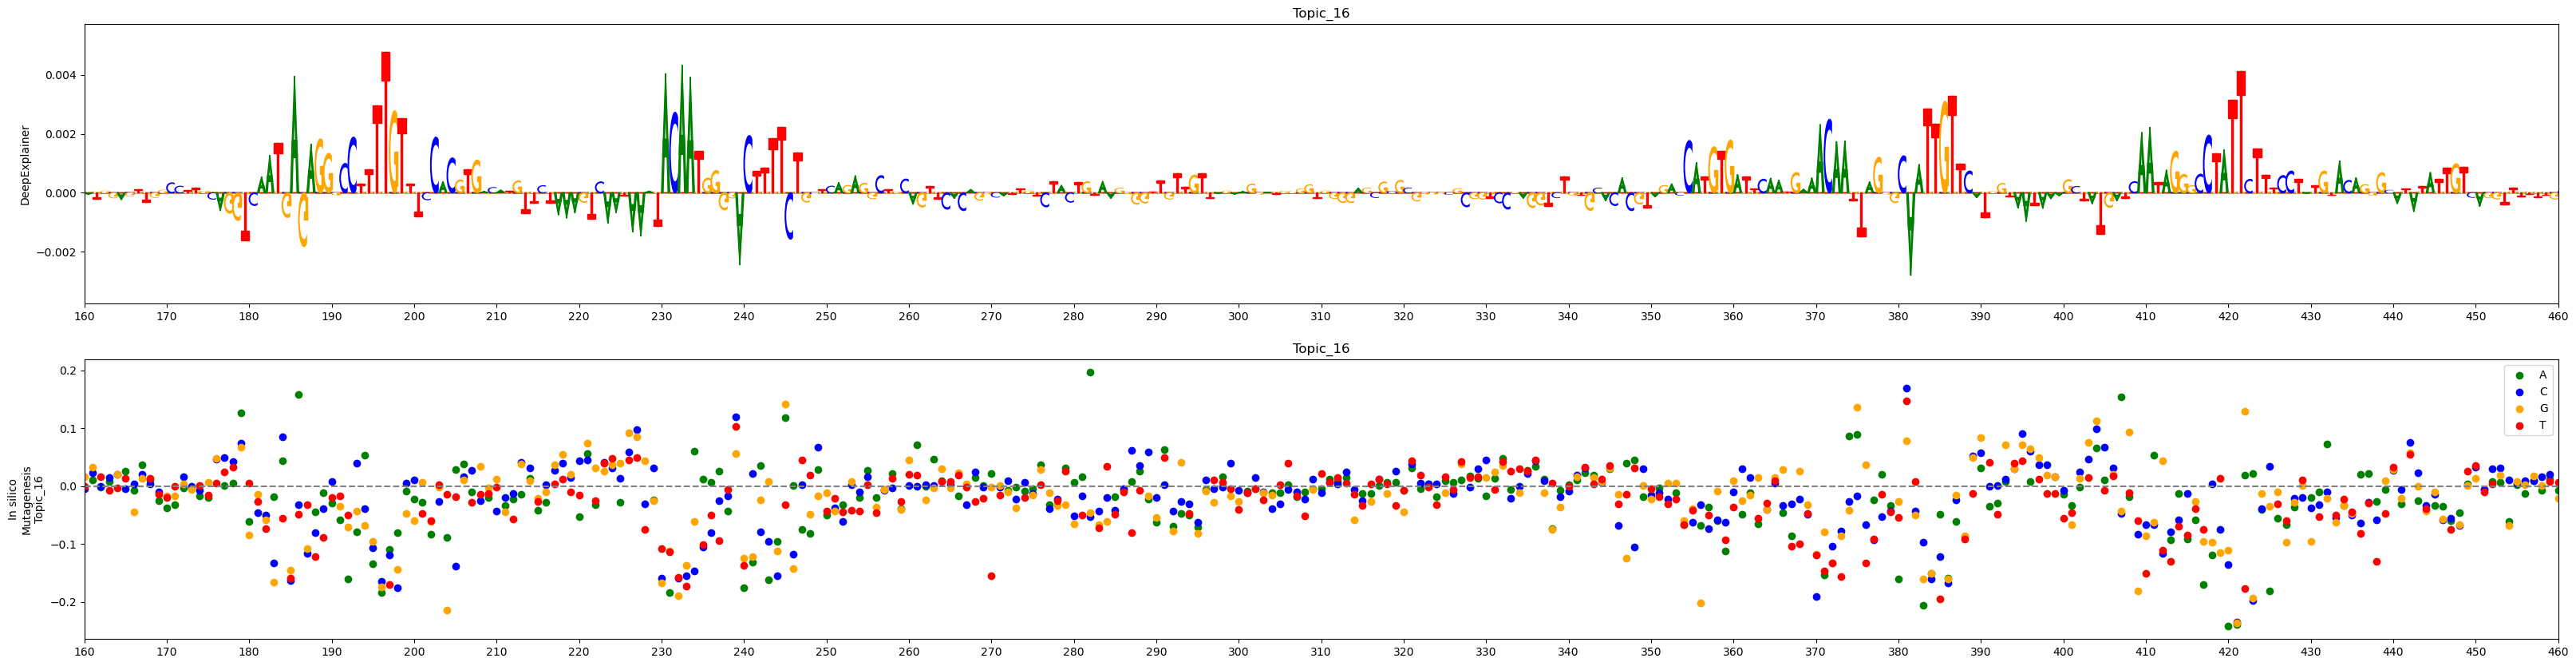

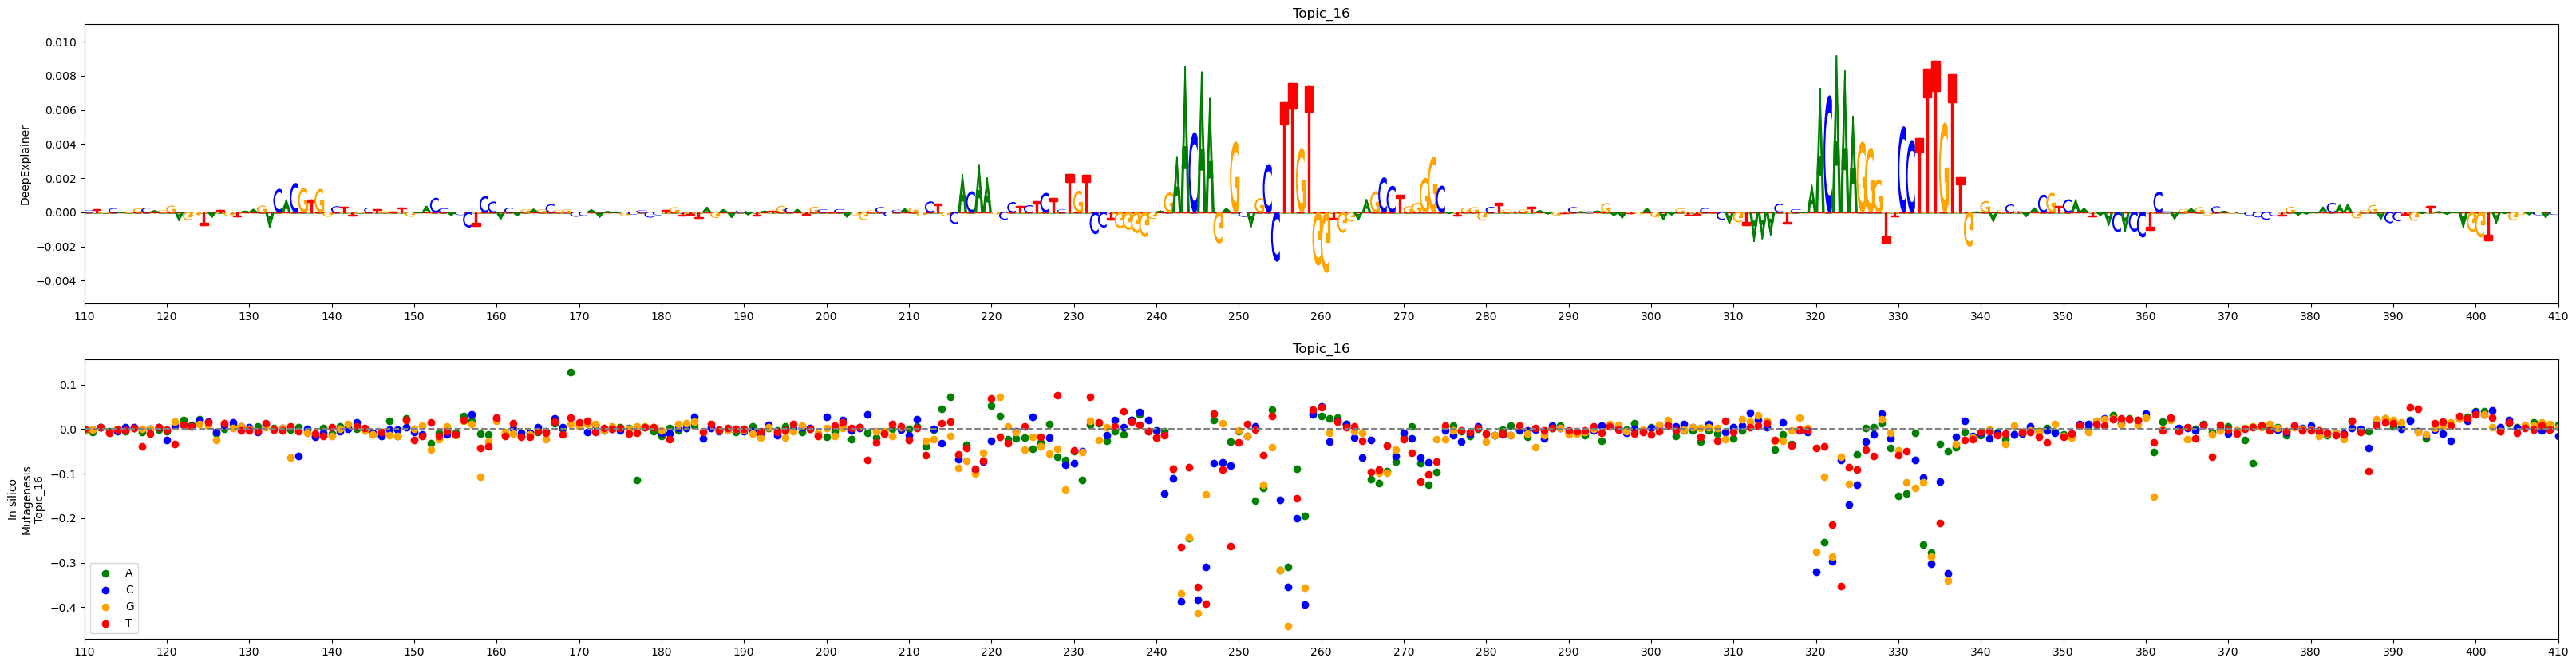

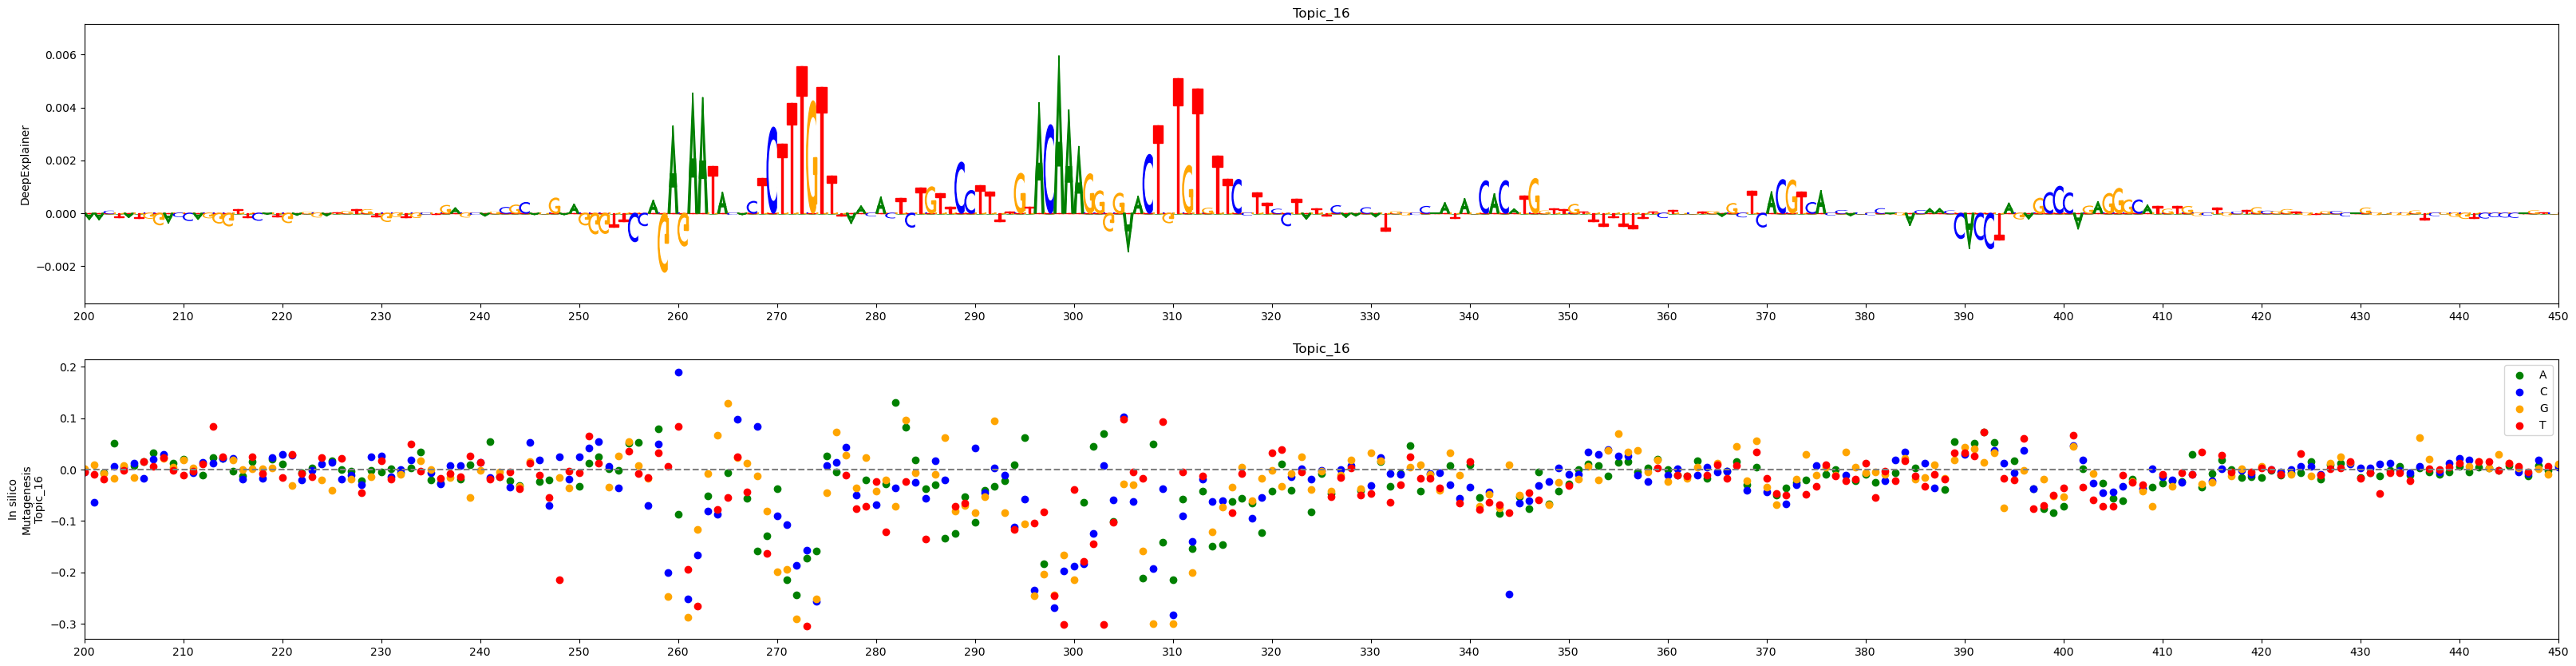

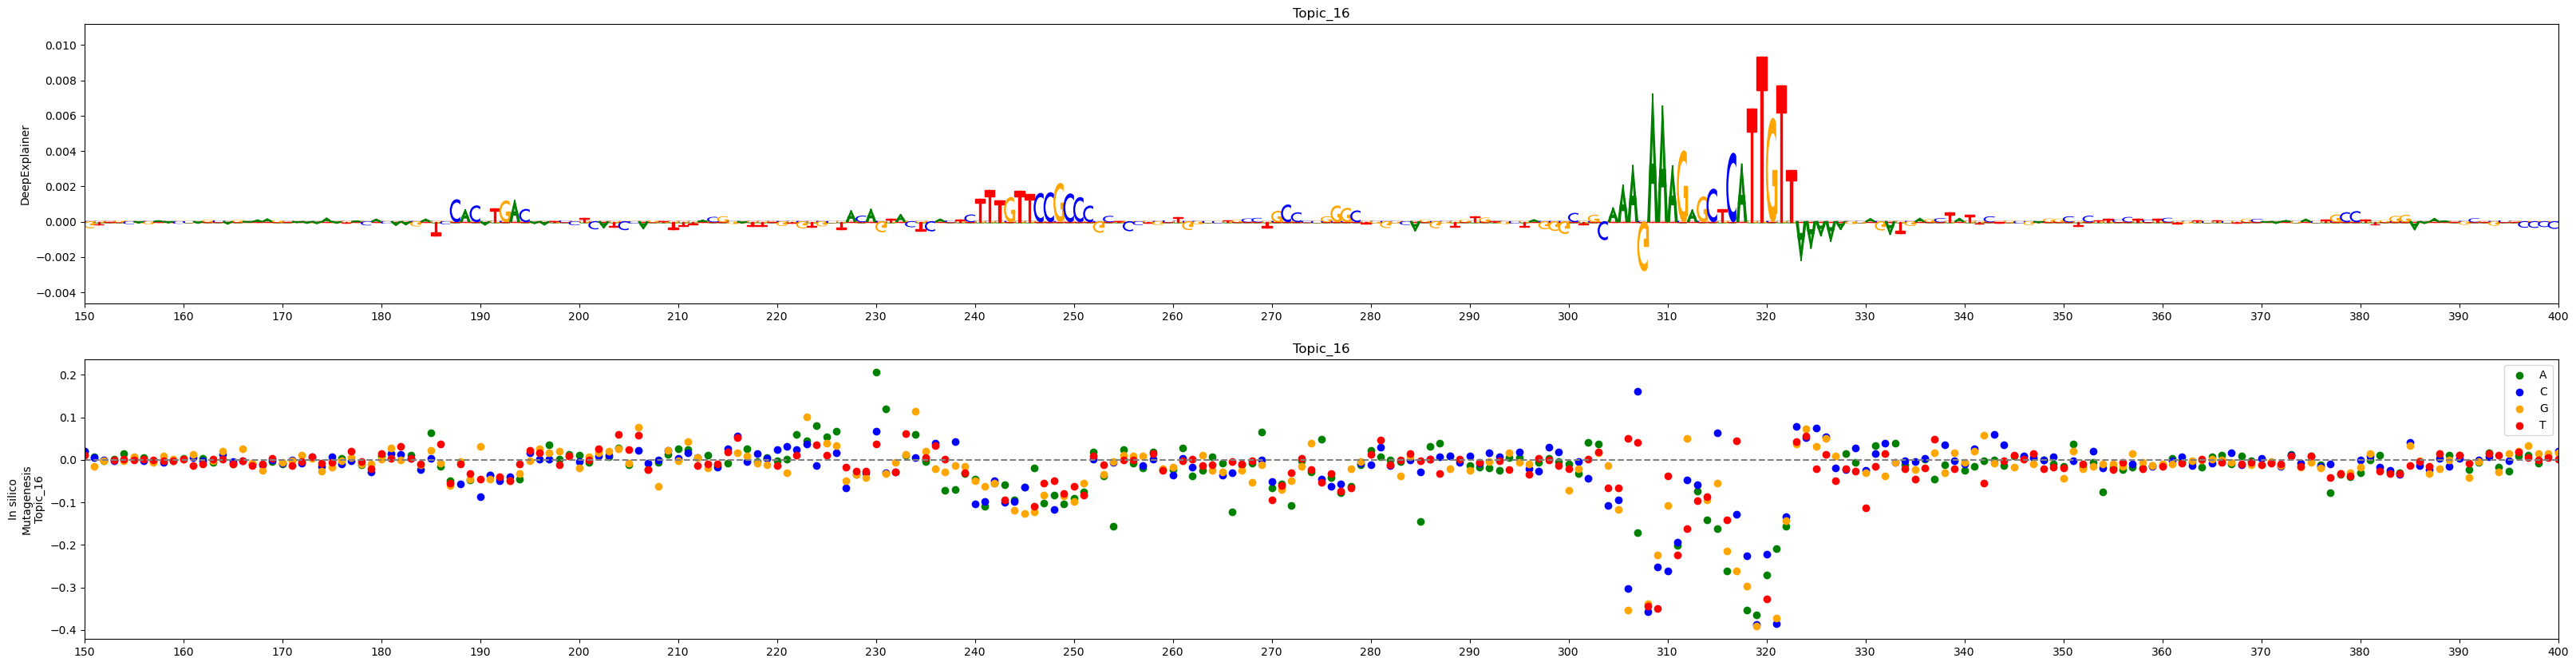

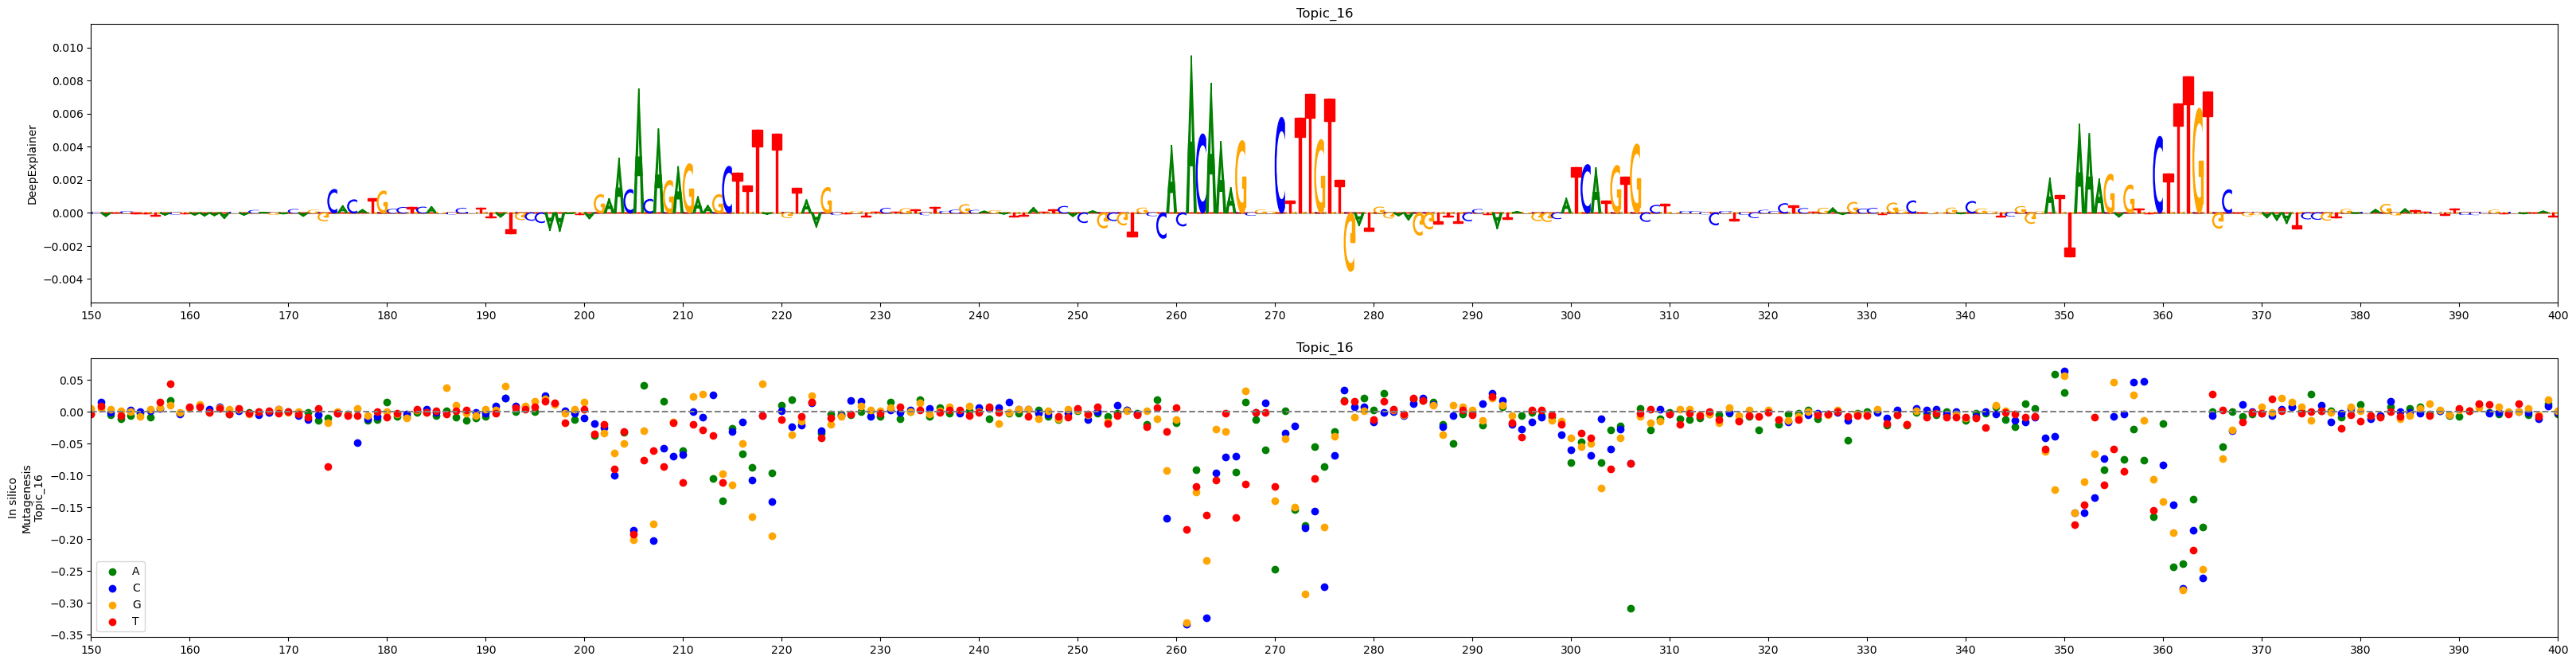

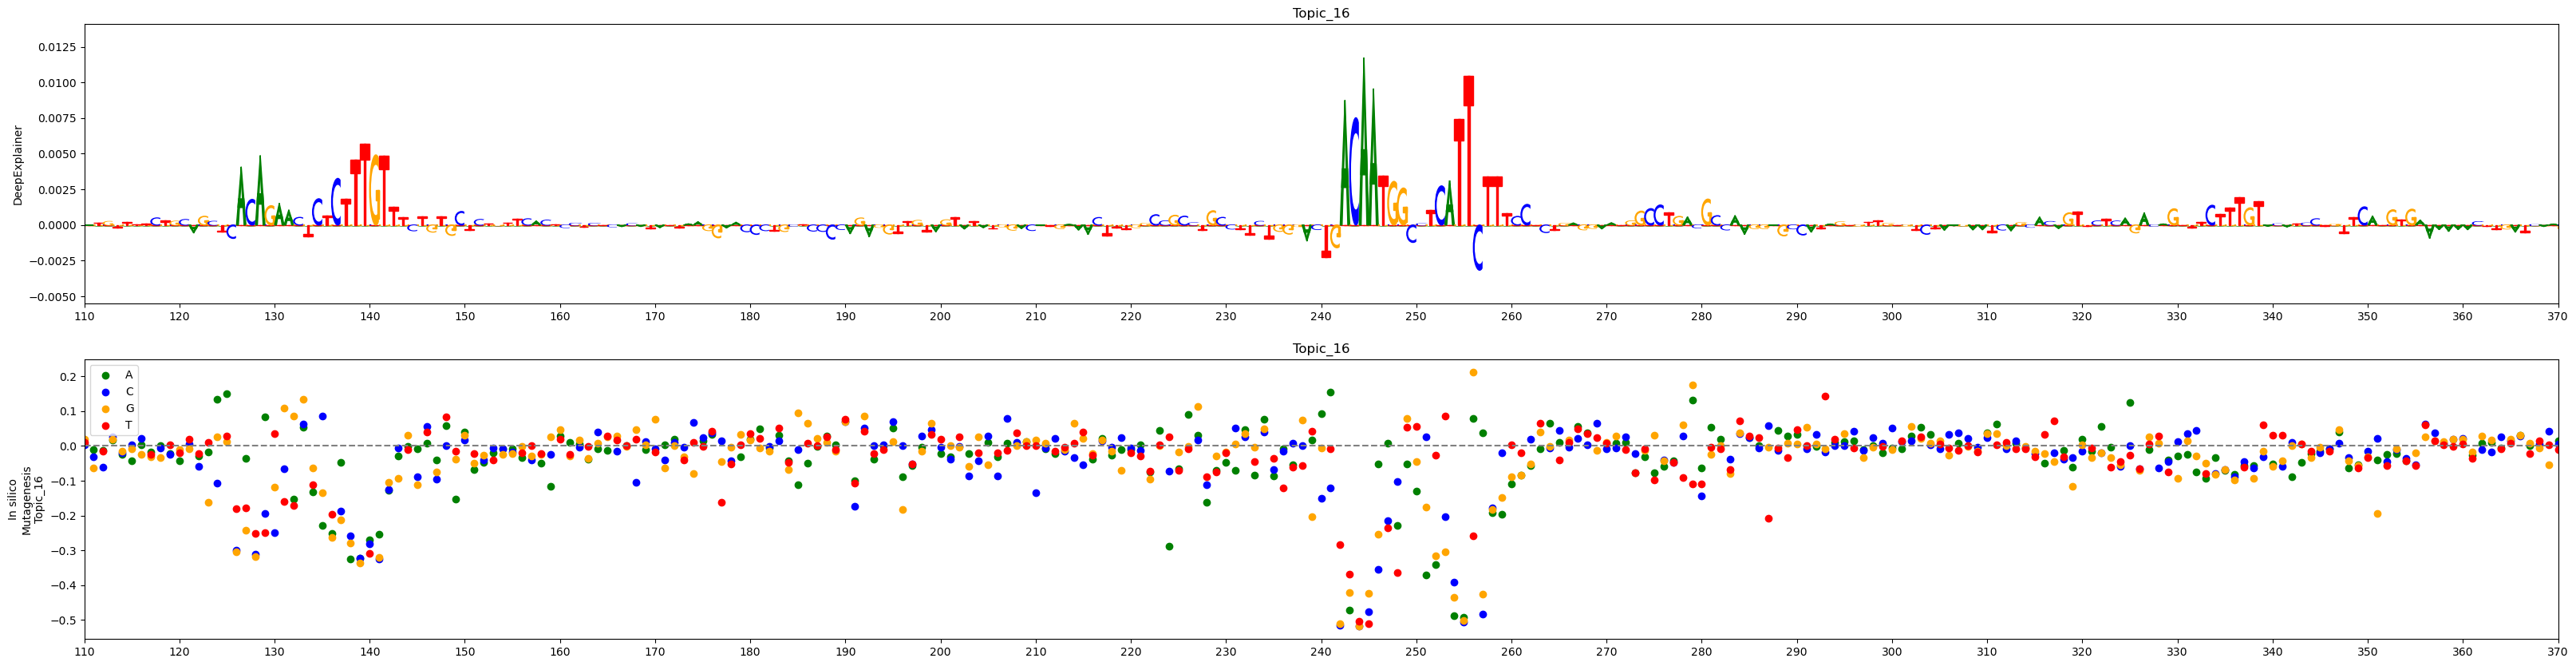

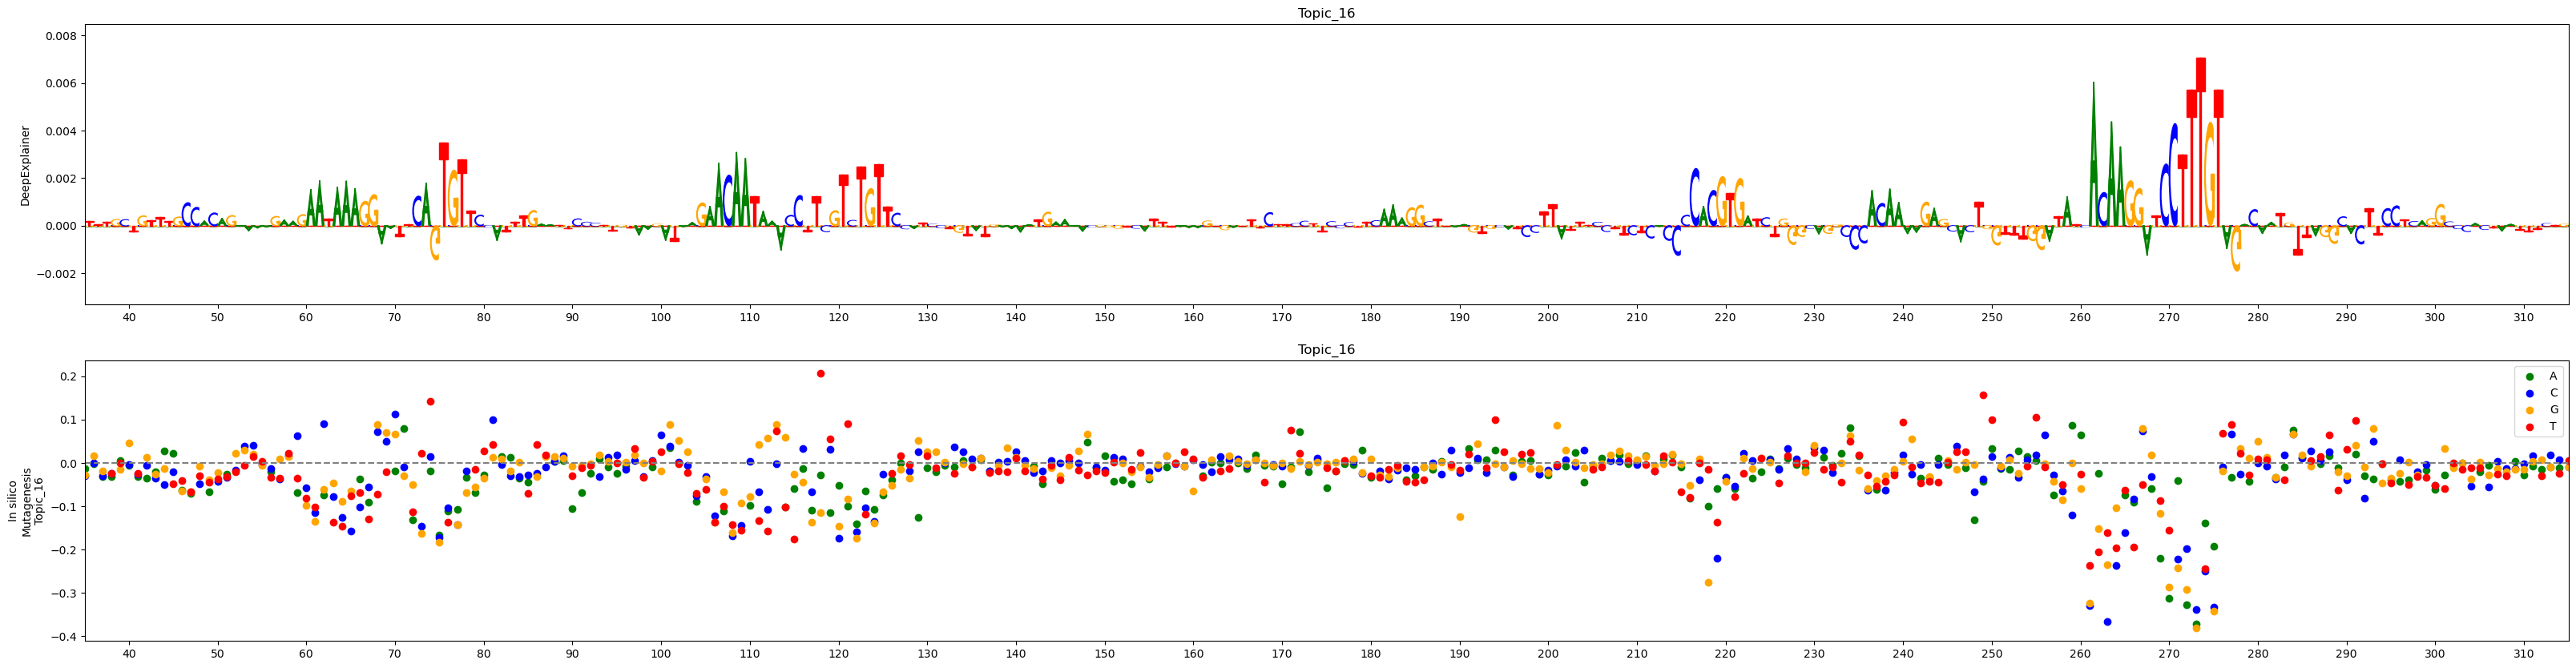

In [58]:
locs = [[120,370],
        [100,390],
        [130,380],
        [160,460],
        [110,410],
        [200,450],
        [150,400],
        [150,400],
        [110,370],
        [35,315]]
for k,region in enumerate(["530_MMgan_160000","807_MMgan_160000","1015_MMgan_160000","1751_MMgan_160000","1747_MMgan_160000",
                        "1931_MMgan_160000","2113_MMgan_160000","2376_MMgan_160000","3045_MMgan_160000","3271_MMgan_160000"]):
    
    st = locs[k][0]
    end = locs[k][1]

    ntrack = 2
    fig = plt.figure(figsize=(40,ntrack*5))
    
    seq_onehot = np.copy(data_dict["MMgan"][160000]["seq"][np.array(data_dict["MMgan"][160000]["ids"])==region])
    ax1 = utils.plot_deepexplainer_givenax_withrc(explainer=exp_dict["deepmel2"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=seq_onehot, class_no = 16)
    ax2 = utils.plot_mutagenesis_givenax_fast_withrc(model=model_dict["deepmel2"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=seq_onehot, class_no = 16)

    ax1.set_xlim([st,end])
    ax2.set_xlim([st,end])


    plt.savefig("figures/gan/"+region+"_"+"GG"+str(k+1)+"_deepexplainer_st"+str(st)+"_end"+str(end)+"_topic16.pdf",transparent=True)